# ANLY 590 Assignment 2

## 1. Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we
use convolutional layers instead of dense layers. We have previously applied
autoencoders to images using only Dense layers and the result worked fairly
well. However, the local spatial correlations of images imply that we should be
able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the Fashion MNIST dataset.
The components of this network will be many of the same pieces we’ve used
with convolutional classification networks: Conv2D, MaxPooling, and so on.
The encoder part of the network should run the input image through a few
convolutional layers of your choice. The decoder part of the network will utilize
UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.

After training your network, visualize some examples of input images and
their decoded reconstruction.

In [1]:
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D
from keras.models import Model
from keras.models import Sequential
from keras import backend as K
from keras import utils, optimizers
from keras.utils.np_utils import to_categorical
from keras.datasets import fashion_mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import cv2
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [0]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

4423680/4422102 [==============================] - 1s 0us/step


In [4]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 10s 159us/step - loss: 0.3560 - val_loss: 0.3156
Epoch 2/30
60000/60000 [==============================] - 8s 131us/step - loss: 0.3075 - val_loss: 0.3071
Epoch 3/30
60000/60000 [==============================] - 8s 129us/step - loss: 0.2983 - val_loss: 0.3020
Epoch 4/30
60000/60000 [==============================] - 8s 127us/step - loss: 0.2935 - val_loss: 0.2975
Epoch 5/30
60000/60000 [==============================] - 8s 126us/step - loss: 0.2903 - val_loss: 0.2913
Epoch 6/30
60000/60000 [==============================] - 7s 124us/step - loss: 0.2876 - val_loss: 0.2890
Epoch 7/30
60000/60000 [==============================] - 7s 123us/step - loss: 0.2858 - val_loss: 0.2872
Epoch 8/30
60000/60000 [==============================] - 8s 133us/step - loss: 0.2842 - val_loss: 0.2850
Epoch 9/30
60000/60000 [==============================] - 8s 127us/step - loss: 0.2829 - val_loss: 0.

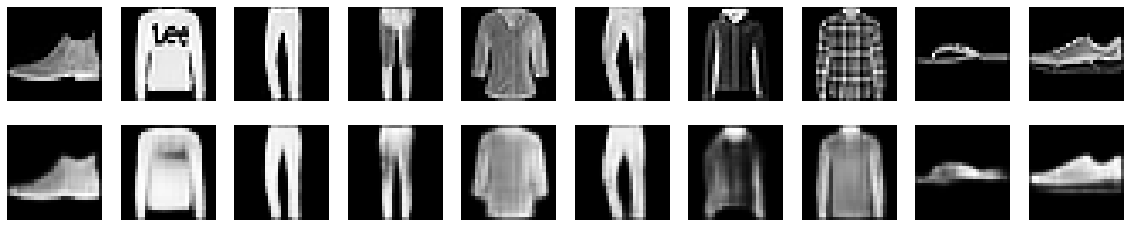

In [5]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Image Classification

We’ll continue to use the Fashion MNIST dataset and build a deep convolutional
network for classification.

## 2.1. Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you’ve made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model’s performance on training
set and test set.

(60000, 28, 28)


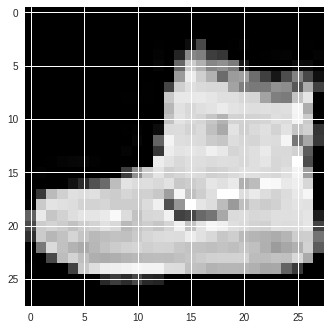

In [6]:
 # Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Shape check and plotting
print(X_train.shape)
plt.imshow(X_train[0])

In [7]:
model = Sequential([
    Conv2D(32, (5, 5), padding="same", input_shape=[28, 28, 1]),
    MaxPooling2D((2,2)),
    Conv2D(64, (5, 5), padding="same"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

X_train = X_train.reshape([-1, 28, 28, 1])
X_test = X_test.reshape([-1, 28, 28, 1])
X_train = X_train/255
X_test = X_test/255

y_train = utils.np_utils.to_categorical(y_train)
y_test = utils.np_utils.to_categorical(y_train)

model.compile(optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=2)

Epoch 1/30
 - 11s - loss: 0.7823 - acc: 0.7293
Epoch 2/30
 - 10s - loss: 0.5104 - acc: 0.8200
Epoch 3/30
 - 11s - loss: 0.4463 - acc: 0.8447
Epoch 4/30
 - 11s - loss: 0.4080 - acc: 0.8570
Epoch 5/30
 - 11s - loss: 0.3845 - acc: 0.8635
Epoch 6/30
 - 10s - loss: 0.3630 - acc: 0.8709
Epoch 7/30
 - 10s - loss: 0.3474 - acc: 0.8763
Epoch 8/30
 - 10s - loss: 0.3327 - acc: 0.8830
Epoch 9/30
 - 11s - loss: 0.3195 - acc: 0.8858
Epoch 10/30
 - 10s - loss: 0.3075 - acc: 0.8903
Epoch 11/30
 - 10s - loss: 0.2975 - acc: 0.8942
Epoch 12/30
 - 10s - loss: 0.2910 - acc: 0.8959
Epoch 13/30
 - 10s - loss: 0.2817 - acc: 0.8985
Epoch 14/30
 - 10s - loss: 0.2741 - acc: 0.9013
Epoch 15/30
 - 10s - loss: 0.2673 - acc: 0.9026
Epoch 16/30
 - 10s - loss: 0.2587 - acc: 0.9067
Epoch 17/30
 - 10s - loss: 0.2536 - acc: 0.9078
Epoch 18/30
 - 10s - loss: 0.2480 - acc: 0.9089
Epoch 19/30
 - 11s - loss: 0.2423 - acc: 0.9116
Epoch 20/30
 - 11s - loss: 0.2364 - acc: 0.9133
Epoch 21/30
 - 11s - loss: 0.2334 - acc: 0.9152
E

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

From the results above, we can see that, by the 30th Epoch, the accuracy is 0.9265 and the loss is 0.2013, which are quite satisfying. They show that this model has a good performance on Fashion Mnist dataset. 

## 2.2.  Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the majority
of your model. You should only train the final Dense layer, all other weightsshould be fixed. You can use whichever pre-trained backbone you like (ResNet,
VGG, etc). Report on your model’s performance on training set and test set.

In [9]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = [cv2.cvtColor(cv2.resize(i,(32,32)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32')
 
X_test  = [cv2.cvtColor(cv2.resize(i,(32,32)), cv2.COLOR_GRAY2BGR) for i in X_test ]
X_test  = np.concatenate([arr[np.newaxis] for arr in X_test] ).astype('float32')

print(X_train.shape)

(60000, 32, 32, 3)


In [10]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="sigmoid"))
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


In [11]:
def build_dim(y):
    y_m = np.zeros(10)
    y_m[y] = 1
    return y_m
    
y_train = np.array([build_dim(y_train[i]) for i in range(len(y_train))])
y_test  = np.array([build_dim(y_test [i]) for i in range(len(y_test ))])

conv_base.trainable = False
model.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-4),metrics=["acc"])
model.fit(X_train, y_train, epochs=10, batch_size = 64)


Epoch 1/10
60000/60000 [==============================] - 26s 439us/step - loss: 0.2985 - acc: 0.9311
Epoch 2/10
60000/60000 [==============================] - 26s 433us/step - loss: 0.1207 - acc: 0.9607
Epoch 3/10
60000/60000 [==============================] - 25s 420us/step - loss: 0.0991 - acc: 0.9656
Epoch 4/10
60000/60000 [==============================] - 25s 419us/step - loss: 0.0881 - acc: 0.9686
Epoch 5/10
60000/60000 [==============================] - 25s 422us/step - loss: 0.0811 - acc: 0.9708
Epoch 6/10
60000/60000 [==============================] - 25s 421us/step - loss: 0.0759 - acc: 0.9722
Epoch 7/10
60000/60000 [==============================] - 25s 423us/step - loss: 0.0720 - acc: 0.9734
Epoch 8/10
60000/60000 [==============================] - 25s 425us/step - loss: 0.0688 - acc: 0.9745
Epoch 9/10
60000/60000 [==============================] - 26s 426us/step - loss: 0.0660 - acc: 0.9753
Epoch 10/10
60000/60000 [==============================] - 26s 427us/step - loss: 

In [12]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 6s 592us/step


[0.09372181837856769, 0.9660900011062622]

From the results above, we can see that the accuracy for both train and test sets are over 0.96. The result shows that the pretrained model has good performance on Fashion Mnist dataset. 

## 3. Text Classification

Build and train a Recurrent Neural Network to solve this text classification task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [0]:
malicious = requests.get('https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt').text.split('\n')
benign = requests.get('https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt').text.split('\n')
text = malicious + benign

label = [0 for _ in range(len(benign))]+[1 for _ in range(len(malicious))]

text_train,text_test,label_train,label_test = train_test_split(text,label,test_size=0.1)

In [0]:
MAX_NUM_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(text_train)
train_sequences = tokenizer.texts_to_sequences(text_train) 
test_sequences = tokenizer.texts_to_sequences(text_test)

In [15]:
print('Sample sequence: ' + ' '.join(str(e) for e in train_sequences[19]))

Sample sequence: 63 3 2 1


In [0]:
text_train_2 = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH)
text_test_2 = pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [17]:
model_RNN = Sequential()
model_RNN.add(Embedding(MAX_NUM_WORDS, 64))
#model.add(SimpleRNN(32))
#model.add(GRU(32))
model_RNN.add(LSTM(32))
model_RNN.add(Dense(1, activation ='sigmoid'))
model_RNN.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
model_RNN.fit(text_train_2, label_train,epochs = 3, batch_size = 64,verbose=1)

Epoch 1/3
60618/60618 [==============================] - 135s 2ms/step - loss: 0.0379 - acc: 0.9905
Epoch 2/3
60618/60618 [==============================] - 132s 2ms/step - loss: 0.0185 - acc: 0.9943
Epoch 3/3
60618/60618 [==============================] - 131s 2ms/step - loss: 0.0179 - acc: 0.9944


In [18]:
model_RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          32000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 44,449
Trainable params: 44,449
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_RNN.evaluate(text_test_2,label_test)

6736/6736 [==============================] - 8s 1ms/step


[0.014530002876540764, 0.995249406175772]

Build and train a 1D CNN for this text classification task. You might gain some
insight and inspiration from these text classification approaches:

In [20]:
label_train_2 = to_categorical(label_train, num_classes = 2)
label_test_2 = to_categorical(label_test, num_classes = 2)

model_CNN = Sequential()
model_CNN.add(Embedding(MAX_NUM_WORDS,64))
model_CNN.add(Conv1D(64,3,padding='valid',activation='relu',strides=1))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(64,activation='relu'))
model_CNN.add(Dense(2,activation='sigmoid'))
model_CNN.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['acc'])
model_CNN.fit(text_train_2, label_train_2,epochs = 3, batch_size = 64,verbose=1)

Epoch 1/3
60618/60618 [==============================] - 9s 153us/step - loss: 0.0417 - acc: 0.9904
Epoch 2/3
60618/60618 [==============================] - 9s 152us/step - loss: 0.0175 - acc: 0.9943
Epoch 3/3
60618/60618 [==============================] - 9s 150us/step - loss: 0.0169 - acc: 0.9943


In [21]:
model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          32000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 48,642
Trainable params: 48,642
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_CNN.evaluate(text_test_2,label_test_2)

6736/6736 [==============================] - 1s 95us/step


[0.014319932985536136, 0.9951009501187649]

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don’t forget to create a train-test split.

In [0]:
label_pred_rnn = model_RNN.predict(text_test_2).ravel()
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(label_test, label_pred_rnn)
label_pred_cnn = model_CNN.predict(text_test_2).ravel()
label_test_2 = np.array(label_test_2).flatten()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(label_test_2, label_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_rnn = auc(fpr_rnn, tpr_rnn)

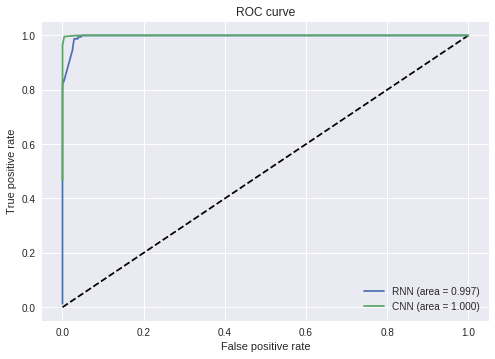

In [24]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rnn, tpr_rnn, label='RNN (area = {:.3f})'.format(auc_rnn))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

From the roc curve, the RNN model performs slightly worse than the CNN model. The CNN model is not perfect as the graph shows, but the accuracy score is equal to 1.000 when three decimal places are kept. Both the models have accuracy over 99%, which are extremely good. 